# Simulating a dynamic recommendation setting

In [1]:
import numpy as np
import pandas as pd
import sys
import pickle

import torch

sys.path.append('/home/caio/dev/')

from dynamicTasteDistortion.simulationConstants import ML_1M_ORACLE_PATH, ITEM_COL, GENRES_COL, USER_COL
from dynamicTasteDistortion.simulation.simulationUtils import setup_user_timestamp_distribution
from bprMf.bpr_mf import bprMFWithClickDebiasing

from calibratedRecs.calibrationUtils import preprocess_genres

In [2]:
movielensOraclePreferenceMatrix = pd.read_csv(f"../{ML_1M_ORACLE_PATH}").drop(columns=["Unnamed: 0"])

In [3]:
movielensOraclePreferenceMatrix

,user,item,genres,rating
0,1,1193,drama,1
1,1,661,animation|children's|musical,0
2,1,914,musical|romance,0
3,1,3408,drama,1
4,1,2355,animation|children's|comedy,1
...,...,...,...,...
19574584,6040,2258,action,0
19574585,6040,2845,drama,0
19574586,6040,3607,comedy|drama|western,1
19574587,6040,690,romance,0


## Simulation process

To simulate users, we'll: 

1. Retain 1000 random users from our synbtethic_data_matrix
2. For each k iteration in the simulation:
    3. Recommend 20 items to the user
        a. For calibration: we recommend 100 but calibrate to 20. This is done to increase recall before running the reranking
    4. Log the clicks 
5. Every 50 iteractions, retrain the recommender
6. Run this for 10_000 iteractions

In [4]:
from dynamicTasteDistortion.simulation.simulator import Simulator

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
timestamp_distribution = setup_user_timestamp_distribution()

In [7]:
users = list(timestamp_distribution.keys())
items = list(movielensOraclePreferenceMatrix["item"].unique())

In [8]:
n_users = len(users)
n_items = len(items)


model = bprMFWithClickDebiasing(num_users=n_users, num_items=n_items, factors=30, n_epochs=1, reg_lambda=5e-4).to(device)

In [ ]:
sim = Simulator(
            oracle_matrix=movielensOraclePreferenceMatrix,
            model=model,
            initial_date=0.0,
            user_timestamp_distribution=timestamp_distribution)

/home/caio/dev/dynamicTasteDistortion/simulation/simulator.py:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bootstrapped_df = pd.concat([bootstrapped_df, round_df], ignore_index=True)


: 

In [ ]:
bootstrapped_df, maces = sim.simulate(L=10, rounds=100)

Processing rounds...:   0%|          | 0/100 [00:00<?, ?it/s]

retraining model...
Calculating mace


Processing rounds...:  10%|█         | 10/100 [01:18<09:01,  6.02s/it]

retraining model...
Calculating mace


Processing rounds...:  20%|██        | 20/100 [10:44<16:03, 12.04s/it]   

retraining model...
Calculating mace


Processing rounds...:  30%|███       | 30/100 [37:08<28:39, 24.56s/it]    

retraining model...
Calculating mace


In [ ]:
item2genreMap = (
    movielensOraclePreferenceMatrix[[ITEM_COL, GENRES_COL]]
    .set_index(ITEM_COL)[GENRES_COL]
    .apply(lambda x: x.split("|"))
    .to_dict()
)

In [ ]:
636 in item2genreMap

False

In [ ]:
with open(f"../data/simulation/movielens_1m_sample_sinthetically_filled.pkl", "rb") as f:
    ml_filled = preprocess_genres(pickle.load(f).drop_duplicates())



In [ ]:

ml_item_to_genre = (
    ml_filled[[ITEM_COL, GENRES_COL]]
    .set_index(ITEM_COL)[GENRES_COL]
    .to_dict()
)

In [ ]:
from simulationUtils import simulate_user_feedback, get_candidate_items

In [ ]:
from metrics import mace

In [ ]:
with open("data/movielens/maces_no_calib_500_users_sample.pkl", "wb") as f:
    pickle.dump(maces, f)

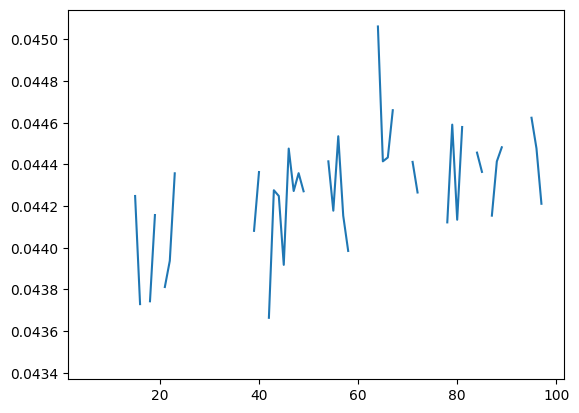

In [ ]:
plt.plot(maces)